# Import

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain

# for reading and displaying images
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# models
from src.data.data_util import *
from src.models.resnet import *
from src.models.levakov_96 import *
from src.models.inception import *
from src.models.dinsdale import *

from src.training.run import *

from torch.optim import *
import torch.optim as optim
from torchsummary import summary

# CAM
from PIL import Image
from matplotlib.pyplot import imshow
from src.visualization.cams import *

from medcam import medcam

In [2]:
from src.config import *
cfg = load_config()

In [27]:
def plot_vismap(brain, vismap, masked=True, threshold=2,
                slc=48, alpha=.6, view=0):
    
    if masked:
        vismap = np.ma.masked_where(vismap < 2, vismap)
    
    fig, axes = plt.subplots(ncols=3, figsize=(15, 6))

    axes[0].set_title('Saggital')
    axes[0].imshow(np.rot90(brain[slc, :, :]), cmap='gray', interpolation='none')
    axes[0].imshow(np.rot90(vismap[slc, :, :]), cmap='jet', interpolation='none', alpha=alpha)
    
    axes[1].set_title('Coronal')
    axes[1].imshow(np.rot90(brain[:, slc, :]), cmap='gray', interpolation='none')
    axes[1].imshow(np.rot90(vismap[:, slc, :]), cmap='jet', interpolation='none', alpha=alpha)

    axes[2].set_title('Horizontal')
    axes[2].imshow(np.rot90(brain[:, :, slc]), cmap='gray', interpolation='none')
    axes[2].imshow(np.rot90(vismap[:, :, slc]), cmap='jet', interpolation='none', alpha=alpha)
    
    plt.show()

In [4]:
from src.visualization.cams import CAM
from src.data.data_util import DatasetPlus
from src.config import *
cfg = load_config()

train_dataset = DatasetPlus(cfg, augment=False)
sample_dl = DataLoader(train_dataset, batch_size=1)
iterator = iter(sample_dl)

cfg.model_name = 'vanilla_residual'
cfg.layers = [16, 32, 64, 128]; cfg.refresh()
model, device = load_model(cfg.model_name, verbose=False, cfg=cfg)
# model.load_state_dict(torch.load('./result/models/2021_03_02_1509/best_resnet_ep31-100_sd42_mae6.811.pth'))

Model Vanilla_residual is selected.


In [12]:
from glob import glob
saved_models = sorted(glob('./result/models/2021_03_22_1039/*.pth'),
                      key=lambda x: int(x.split('ep')[1].split('-')[0]))

In [16]:
date, pth_name = state.split('/')[-1].split('\\')

In [25]:
def parser(state):
    
    date, pth_name = state.split('/')[-1].split('\\')
    model_name = pth_name.split('_ep')[0]
    epoch = pth_name.split('_ep')[-1].split('-')[0]
    
    return date, epoch

Epoch 0


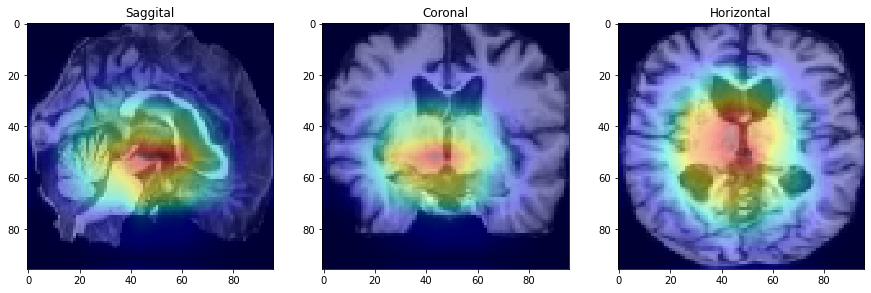

Epoch 5


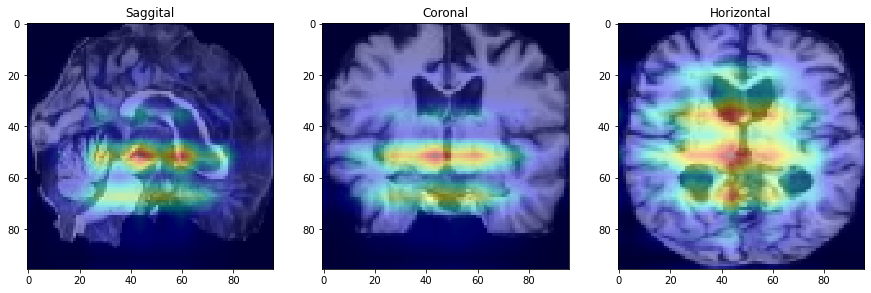

Epoch 8


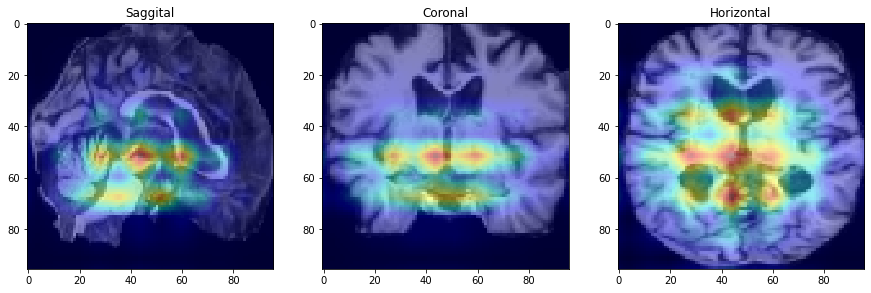

Epoch 10


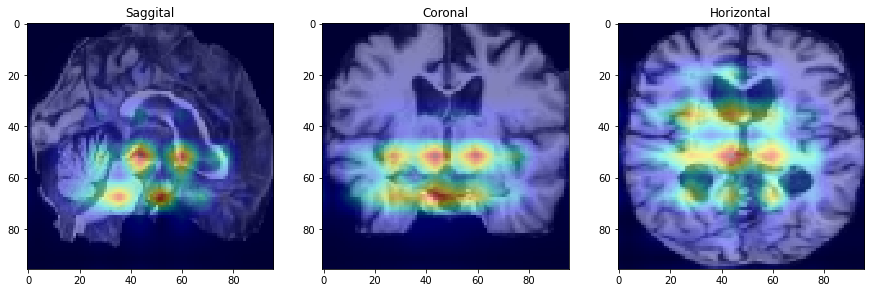

Epoch 15


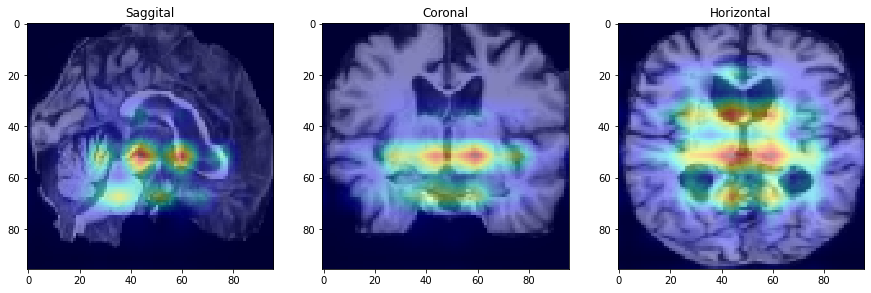

Epoch 16


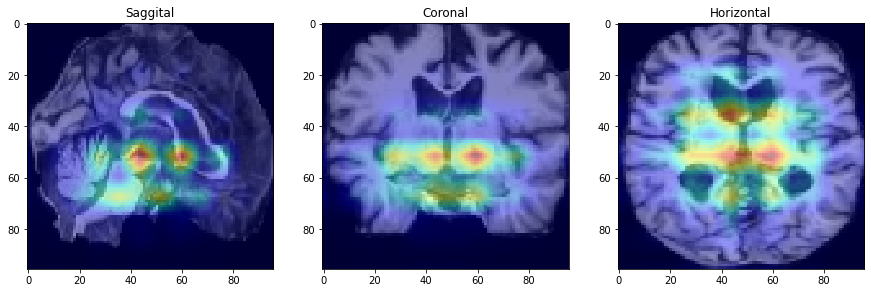

Epoch 20


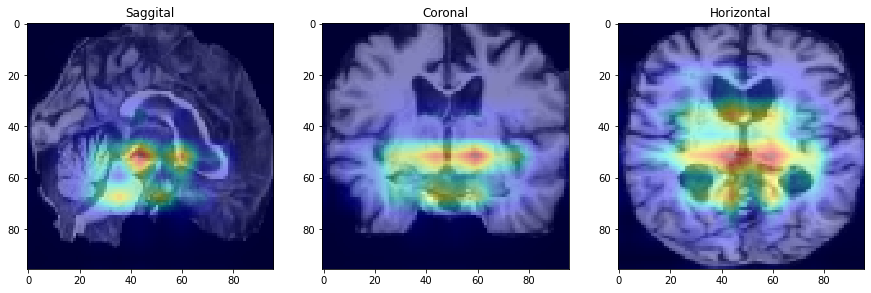

In [42]:
data = next(iter(sample_dl))
layer_idx = 4 # range from 0 to 15
for state in saved_models:
    
    _, epoch = parser(state)
    print(f'Epoch {epoch}')
    model.load_state_dict(torch.load(state))
    resized_cam = run_gradcam(model, data, cfg)[layer_idx]
    plot_vismap(data[0][0][0], resized_cam, alpha=.4, masked=False)